### Radiative-convective equilibrium as an idealized problem for climate

Imagine a pot of water on a stove, heated from below. As the water in the bottom of the pot warms it becomes less dense than the water above it and rises, causing the water to overturn (circulate in the vertical). Cooling from the top can also cause an overturning circulation - this is what you see in a bowl of miso soup. Any temperature profile in which deeper water is warmer than shallow water is "unstable" in this way, and will mix in the vertical. The vertical water motions are called "convection". 

The earth's atmosphere differs from a bowl of miso soup in three important ways (for the purposes of this discussion). 

First, the atmosphere is compressible, meaning that the pressure decreases roughly exponentially with distance from the surface. Conservation of energy means that the temperature of the air also has to decrease with height. This means that the condition of stability isn't "is the air below a given location warmer/less dense than the air at the location" but rather "will the air below **be**  warmer/less dense if it's raised to the location?" (In the atmospheric sciences it's common to use a "potential temperature" that accounts for this energy-conserving relationship between pressure and temperature.) 

Second, the atmosphere contains water vapor. The maximum amount of water vapor is controlled by temperature. When air cools enough, then, the water vapor condenses, which gives off energy. This means that the temperature profile in which water is condensing (i.e. inside a cloud) cools less rapidly with height than does dry air. Two consequences are a) that convection in the atmosphere is a balances of small regions of strong, upward motion in which water is condensing (clouds!) surrounded by large regions of gentle downward motion with no clouds. A second is that the stabiity condition is phrased with respect to motions in which water is condensing - a less stringent threshold than a dry atmosphere. 

Finally, unlike soup cooled from the top surface, the atmosphere cools throughout its depth, because water vapor is an effective emitter of longwave radiation. 

**Radiative-convective equilibrium** is very simple representation of the earth's climate, in which the radiative cooling of the atmosphere is balanced by convective motions. 

### Background on konrad 

`konrad` is a modern implementation of a single-column radiative-convective equilibrium model. The convective motions aren't explicit - instead, as the cooling makes the atmosphere unstable, the temperature and moisture profiles are adjusted to reflect vertical mixing in an energy-conserving way to maintain a stable profile. 

In other sections of the course you'll be using very small models for which it will be straightforward enough to read the entire implementation. `konrad` is more involved so the focus will be on framing and answering questions and interpreting the results. 

The model's technical documention -- lists of all the components and functions -- is available on [ReadTheDocs](https://konrad.readthedocs.io). The konrad authors' ["How to konrad"](https://atmtools.github.io/konrad) Jupyter book is a tutorial in using the model. All the questions we asked below are found in the tutorial but you should arrive at your own answers. 

### The assignment

In the next two labs we will use konrad to explore questions of climate, including characterizing forcing, feedbacks, and climate sensitivty. Much of the material is covered in  Kluft et al. 2019, Re-examining the first climate models: climate sensitivity of a modern radiative–convective equilibrium model, doi:[10.1175/JCLI-D-18-0774.1](https://doi.org/10.1175/JCLI-D-18-0774.1).

We'll start by importing the Python modules needed including the `konrad` model itself

In [1]:
# Import needed Python modules 
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

import numpy as np

import konrad

#### Preliminaries

The konrad developers have provided many of the pieces needed to specify and compute a radiative-convective equilibrium problem. The first step is to decide on a vertical pressure grid and create an atmosphere discretized on this grid. 

In [2]:
# Choose pressure levels according to Equation 1 in Kluft et al. 2019 
# https://konrad.readthedocs.io/_autosummary/konrad.utils.get_quadratic_pgrid.html#konrad.utils.get_quadratic_pgrid
phlev = konrad.utils.get_quadratic_pgrid(1000e2, 10, 128) 

Define an atmosphere on this grid

In [3]:
# Initial temperature profiles and composition 
atmosphere = konrad.atmosphere.Atmosphere(phlev)
atmosphere.atmosphere_variables

['T',
 'H2O',
 'N2O',
 'O3',
 'O2',
 'CO2',
 'CO',
 'CH4',
 'CFC11',
 'CFC12',
 'CFC22',
 'CCl4']

First let's ensure set the CO$_2$ concentration to pre-industrial values. `konrad` will update the temperature and humidity `atmosphere` object as it runs so we'll save as copy as initial conditions

In [4]:
atmosphere["CO2"][:] = 280E-6
initial_conds = atmosphere.copy()

konrad defines an RCE calculation as a [set of choices](https://konrad.readthedocs.io/_autosummary/konrad.core.RCE.__init__.html). Many of the most important choices (radiation, ozone, humidity, surface, cloud, convection/vertical mixing, lapse rate, and large-scale upwelling) are specified as functions rather than discrete values. Start with the default configuation: 

In [5]:
baseline = konrad.RCE(atmosphere)

Many of the sub-models have variables associated with them. The radiation sub-model, for example, has fluxes of longwave (`lw`) and shortwave (`sw`) radiation up and down (`u`, `d`), along with heating rates. There are no clouds in our simulation so we can ignore the clear-sky values.  

In [6]:
baseline.radiation.data_vars 

{'lw_htngrt': (('time', 'plev'), None),
 'lw_htngrt_clr': (('time', 'plev'), None),
 'lw_flxu': (('time', 'phlev'), None),
 'lw_flxd': (('time', 'phlev'), None),
 'lw_flxu_clr': (('time', 'phlev'), None),
 'lw_flxd_clr': (('time', 'phlev'), None),
 'sw_htngrt': (('time', 'plev'), None),
 'sw_htngrt_clr': (('time', 'plev'), None),
 'sw_flxu': (('time', 'phlev'), None),
 'sw_flxd': (('time', 'phlev'), None),
 'sw_flxu_clr': (('time', 'phlev'), None),
 'sw_flxd_clr': (('time', 'phlev'), None),
 'net_htngrt': (('time', 'plev'), None),
 'net_htngrt_clr': (('time', 'plev'), None),
 'toa': (('time',), None)}

Two interleaved grids are used in the vertical: state variables (temperature, concentration, humidity) are on full levels (`plev`), while fluxes (especially radiation variables) are on half-levels (`phlev`). The surface air is at `phlev[0]`; the top of the atmosphere is `phlev[-1]`  and there's one more half-level than full level. 

In [7]:
phlev[0], phlev[-1]

(100000.00000000009, 10.0)

Variables are undefined until the model is run, normally to convergence, which takes about 10 seconds on the LEAPangeo hub

In [8]:
baseline.run() 

Variables will now have valid values. The first axis is time but, by default, only the values at equilibrium are available: 

In [9]:
baseline.radiation["lw_flxu"].shape

(1, 128)

Remember, `konrad.atmosphere` and the `atmosphere` are the same (they "point to the same memory")

In [10]:
print(np.max(atmosphere['T'] - baseline.atmosphere['T']))

0.0


**The atmosphere in RCE**: We can, for example, plot the arbitrary initial and final equilibrium profiles of temperature. We'll plot these as a function of pressure, which varies over three orders of magnitude (so we use a log scale) and decreases as altitide increases (so we'll plot an inverted y-axis, limiting to pressures higher than 1 hPa). 
<a id='temp_profiles'></a>

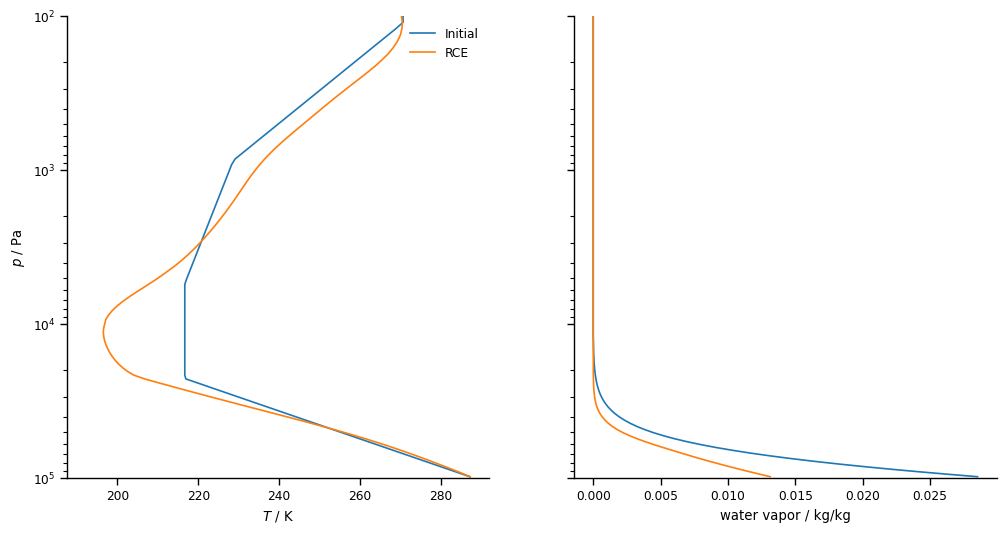

In [11]:
sns.set_context("paper")

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=[12, 6], sharey=True)

ax0.semilogy(initial_conds['T'][0,:], initial_conds['plev'], label = "Initial")
ax0.semilogy(atmosphere   ['T'][0,:], initial_conds['plev'], label = "RCE")
ax0.set_ylim(phlev[0], 100.) 
ax0.set_ylabel("$p$ / Pa")
ax0.set_xlabel("$T$ / K")
ax0.legend(frameon = False)

ax1.semilogy(initial_conds['H2O'][0,:], initial_conds['plev'])
ax1.semilogy(atmosphere   ['H2O'][0,:], initial_conds['plev'])
ax1.set_xlabel("water vapor / kg/kg")

sns.despine() 

**Radiation in RCE**: What does the energy budget look like in the baseline RCE state? We can plot the four components of the radiation budget: up- and down-going radiation for solar (shortwave or sw) and terrestrial (longwave or lw) radiation. The radiation model also tells us the net heating rate. 

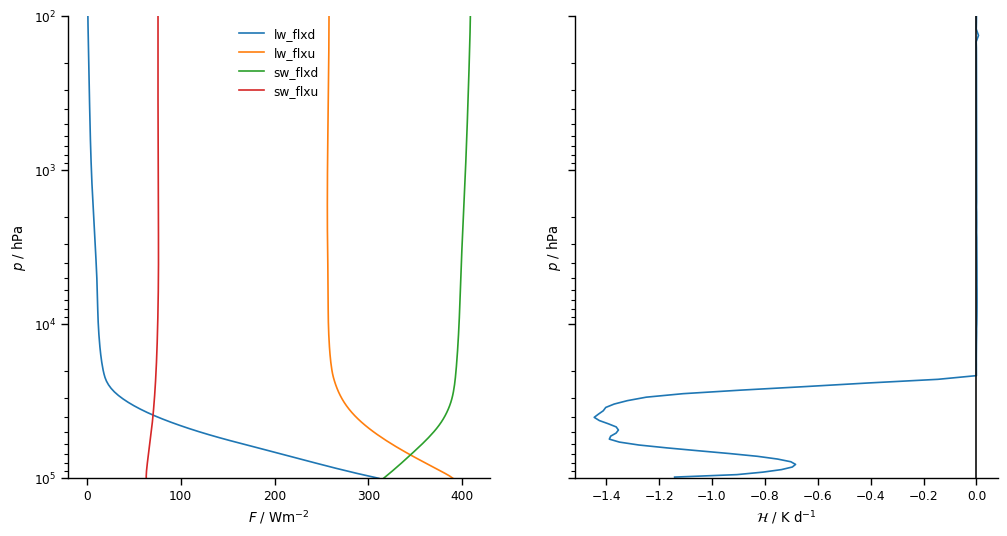

In [12]:
# If we were doing this for publication we'd assign each variable a distinct color, different from plots above and below

sns.set_context("paper")

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=[12, 6], sharey=True)
# Loop over the four fluxes that make up the 
for v in ['lw_flxd', 'lw_flxu', 'sw_flxd', 'sw_flxu']:
    ax0.semilogy(baseline.radiation[v][0,:], initial_conds['phlev'], label=v)
ax0.set_ylabel("$p$ / hPa")
ax0.set_xlabel("$F$ / Wm$^{-2}$")
ax0.legend(frameon = False) 
ax0.set_ylim(phlev[0], 100.) 


ax1.semilogy(baseline.radiation['net_htngrt_clr'][0,:],       initial_conds['plev'])
ax1.set_ylabel("$p$ / hPa")
ax1.set_xlabel("$\mathcal{H}$ / K d$^{-1}$")
ax1.axvline(0, color="0.05")
sns.despine() 

Compare the down-going and up-going amounts of solar and terrestrial radiation. Do you understand why they have the relative values they do?  

At pressures greater than 1000 Pa, or 100 hPa, i.e. in the lowest 90% of mass in the atmopheres, there's a non-zero radiative cooling rate of roughly 1 $K/d$. That's the cooling that's making the atmosphere unstable and leading to convection. 

The upper part of the atmosphere -- the stratosphere and above -- is in radiative equilibrium. 

What is the total top-of-atmosphere energy imbalance? You'll see it's far from 0, meaning that the tropical region represented by RCE absorbs more sunlight than it emits, on average. On earth this energy is exported from the tropics towards the poles by the atmospheric and oceanic circulations. 

In [13]:
baseline.radiation["toa"]

array([75.9038868])

#### Question 1 
What is the temperature struture of the (tropical) atmosphere under present-day conditions (that's the figure above), and how does this depend on surface temperature and humidity ?

**Surface temperature**: By [default](https://konrad.readthedocs.io/_autosummary/konrad.core.RCE.html) konrad uses a [fixed surface temperature of 288 K](https://konrad.readthedocs.io/_autosummary/konrad.surface.FixedTemperature.html#konrad.surface.FixedTemperature). This can be changed by specifying a different surface temperaure when setting up the RCE calculation:  

In [14]:
pert_Ts_286 = konrad.RCE(atmosphere = initial_conds.copy(), 
                         surface=konrad.surface.FixedTemperature(temperature=286))
pert_Ts_286.run()

In [15]:
print("Near-surface temp in baseline:  ", f'{baseline.atmosphere   ["T"][0, 0]:6.4}') 
print("Near-surface temp for T_s = 286:", f'{pert_Ts_286.atmosphere["T"][0, 0]:6.4}') 

Near-surface temp in baseline:    287.3
Near-surface temp for T_s = 286:  285.2


**Humidity**: By default konrad assumes a constant relative humidity of 80% in the lower part of the atmosphere and a constant specific humdity (water vapor concentration, or absolute humidity) in the stratosphere -- a reasonable simplification to the real world. 

In [16]:
pert_rh_05 = konrad.RCE(atmosphere = initial_conds.copy(), 
                         humidity=konrad.humidity.FixedRH(konrad.humidity.VerticallyUniform(0.5)))
pert_rh_05.run()

In [17]:
print("Near-surface water vapor in baseline: ", f'{baseline.atmosphere   ["H2O"][0, 0]*1000:4.3} g/kg') 
print("Near-surface water vapor for RH = 50%:", f'{pert_rh_05 .atmosphere["H2O"][0, 0]*1000:4.3} g/kg') 

Near-surface water vapor in baseline:  13.1 g/kg
Near-surface water vapor for RH = 50%: 8.21 g/kg


**Please**

- Following the [example above](#temp_profiles), plot the vertical structure of temperature for several values of surface temperature and humidity. It'll be more interesting to plot the difference from the surface temperature so all the figures are on the same scale

#### Question 2
What is the instantaneous radiative forcing due to doubling CO$_2$ concentrations from pre-industrial values, and how does this depend on humidity and temperature? 

First it'll be useful to write a function that tells us the net downward radiation (down minus up, both shortwave and longwave) 

In [18]:
def compute_N(radiation): 
    """
    Compute net downward radiation from down- and up-going longwave and shortwave radiation 
    """
    return(radiation["lw_flxd"] - radiation["lw_flxu"] + 
           radiation["sw_flxd"] - radiation["sw_flxu"])

**Computing radiation fields**: Each component of konrad can be run on its own, so we can compute the instantaneous radiative forcing $F_i$ as the change in net radiation cased by a change in CO$_2$ concentration, i.e. 

In [19]:
# Re-equilibrate the temperature and humidity fields to baseline conditions
rad = konrad.RCE(initial_conds.copy())
rad.run() 
pi_rad = copy.deepcopy(rad.radiation)
# What is the profile of net radiation under pre-industrial conditions? 
N_prof = compute_N(pi_rad)

# Calculate OLR at perturbed atmospheric state.
atmos_2xCO2 = rad.atmosphere.copy() 
# double the CO2 concentration
atmos_2xCO2["CO2"][:] *= 2

# Compute new radiation fields with changing temperature or humidity 
rad.radiation.update_heatingrates(atmos_2xCO2)
twox_rad = copy.deepcopy(rad.radiation)

# The change in the net radiation field as a function of pressure 
inst_rad_forcing = (compute_N(twox_rad) - compute_N(pi_rad))[0,:]

- Plot the profiles of $F_i$ for the baseline case
- Plot the dependence of $F_i$ at the top of the atmosphere on surface temperature and/or humidity for several values of each variable

#### Question 3 
What is the effective radiative forcing due to doubling CO2 concentrations from pre-industrial values, and what is the relationship between stratospheric cooling and the radiative adjustment? 

Effective radiative forcing $F$ is the change in N (normally at the top of the atmosphere) allowing all aspects of the system _except the surface temperature_ to respond to the forcing agent. Recall, though, that konrad specifices surface temperature as fixed, so $F$ can be computed by changing CO$_2$ concentrations, running the model to equilirium with the same surface temperture, and comparing the net radiation to the unperturbed state. 

- Compute the effective radiative forcing for CO$_2$ concentrations doubled from pre-industrial concentrations (e.g. from 280 -> 560 ppmv). Compare the profile of the effective radiative forcing to the profile of instantaneous radiative forcing in question 3. 
- What fraction of $F$ is the adjustment by stratospheric cooling? 
- Plot the stratospheric adjustment - the change in stratospheric temperature profiles - for 2$\times$CO$_2$ and 0.5$\times$CO$_2$.
- Plot the top-of-atmosphere ERF for several values of surface temperature and/or humidity. Is the dependence the same as for $F_i$? 

#### Question 4

What is the climate sensitivity in radiative-convective equlibrium, and how does this depend on humidity and/or initial surface temperature? 

**Climate sensitivity, method 1**

Estimate climate sensitivty by computing the climate feedback and combining this with estimates of forcing by doubled CO2 contentrations. 

- Establish one or more baseline simulations of RCE, similar to those used in question 1, but varying humidity and/or surface temperature.  
- Change the surface temperature, compute the change in top-of-atmosphere net radiation $N$, and the climate feedback $\lambda = \frac{d N}{d T_s}$. Does $\lambda$ depend on humidity or surface temperature? 
- Estimate climate sensitivity $S$ from the effective radiative forcing (Question 3) and the climate feedback $S = \frac{F_{2\times CO_2}}{\lambda}$
<a id='S_from_lambda_F'></a>

**Climate sensitivity, method 2**

Another way to compute climate sensitity is by changing CO$_2$ concentrations and running to equilibrium while letting the surface temperature evolve. For this we have to specify a different model of the surface: a "slab ocean", meaning a heat resevoir scaled to the capacity of a shallow layer of water, with a heat sink that allows the model to come into balance with a specified surface temperature. From 

In [20]:
#
#  Run the model with specified surface temperature to compute the total imbalance 
#
fixed_SST = konrad.RCE(
    initial_conds.copy(),
    surface=konrad.surface.FixedTemperature(temperature=295.0),
)
fixed_SST.run()  
print("Near-surface temp with fixed surface temperature:  ", f'{fixed_SST.atmosphere   ["T"][0, 0]:6.4}') 

ml_ocean = konrad.surface.SlabOcean(
    temperature=295.0,
    heat_sink=fixed_SST.radiation["toa"][-1],
    depth=10.,
)

#
# A slab ocean model with a heat sink that matches the imbalance should have nearly the same surface air temperature 
#
slab_ocean = konrad.RCE(
    fixed_SST.atmosphere.copy(),
    surface=ml_ocean,
    timestep='12h',
    max_duration='300d',  # Set runtime.
)
slab_ocean.run()
print("Near-surface temp with slab ocean:", f'{slab_ocean.atmosphere["T"][0, 0]:6.4}') 


Near-surface temp with fixed surface temperature:    294.4
Near-surface temp with slab ocean:  294.4


- From the baseline simulations, increasing $CO_2$ concentrations by a factor of 2 and run to equilibrium. (See [How to konrad](https://atmtools.github.io/konrad/feedback.html)) How long must you run the simulation for the temperature to equilibrate (reach a stable value?)
- How do estimates of $S$ compare to those estimated [more indirectly](#S_from_lambda_F)? 
- How do estimates of $\lambda$ inferred from $S$ and $F$ compare to those estimated from changing surface temperature? 